DESCRIÇÃO

Neste desafio iremos atualizar a implementação do sistema bancário, para armazenar os dados de clientes e contas bancárias em objetos ao invés de dicionários. O código deve seguir o modelo de classes UML.

## REGRAS
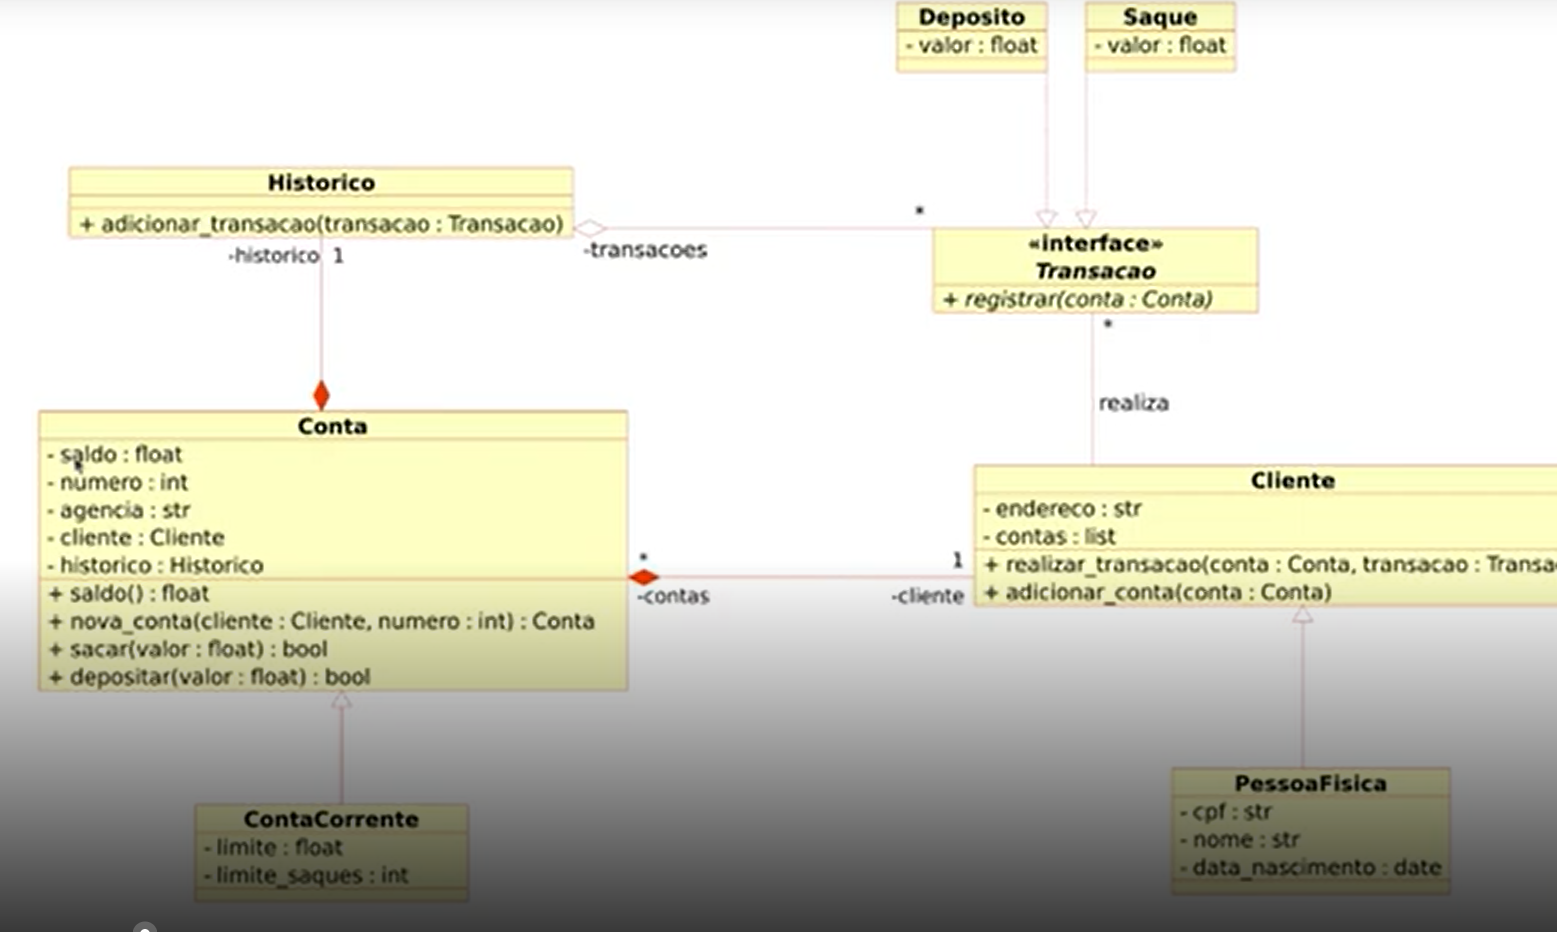

In [ ]:
import textwrap
from abc import ABC, abstractmethod
from datetime import date, timedelta # Importando 'date' e 'timedelta'
# No qual 'date' é usado para manipular datas e 'timedelta' para calcular diferenças entre datas.

### MUDANÇA ESTRUTURAL: Reformulação completa dos planos ###
PLANOS = {
    "gratuito": {
        "nome": "Gratuito",
        "custo_mensal": 0.0,
        "limite": 500.0,
        "limite_saques": 2,
        "limite_credito": 0.0
    },
    "prata": {
        "nome": "Prata",
        "custo_mensal": 19.90,
        "limite": 2000.0,
        "limite_saques": 5,
        "limite_credito": 1000.0
    },
    "ouro": {
        "nome": "Ouro",
        "custo_mensal": 39.90,
        "limite": 5000.0,
        "limite_saques": 10,
        "limite_credito": 2500.0
    },
    "black": {
        "nome": "Black",
        "custo_mensal": 79.90,
        "limite": 10000.0,
        "limite_saques": 999, # Ilimitado na prática
        "limite_credito": 10000.0
    }
}

# (As classes Historico, Transacao, Deposito, Saque, Cliente e PessoaFisica permanecem as mesmas)
# ...
class Historico:
    def __init__(self):
        self._transacoes = []

    @property
    def transacoes(self):
        return self._transacoes

    def adicionar_transacao(self, transacao):
        self._transacoes.append({
            "tipo": transacao.__class__.__name__,
            "valor": transacao.valor,
            "data": date.today().strftime("%d-%m-%Y"),
        })

class Transacao(ABC):
    @property
    @abstractmethod
    def valor(self):
        pass

    @abstractmethod
    def registrar(self, conta):
        pass

class Deposito(Transacao):
    def __init__(self, valor):
        self._valor = valor

    @property
    def valor(self):
        return self._valor

    def registrar(self, conta):
        if conta.depositar(self.valor):
            conta.historico.adicionar_transacao(self)

class Saque(Transacao):
    def __init__(self, valor):
        self._valor = valor

    @property
    def valor(self):
        return self._valor

    def registrar(self, conta):
        if conta.sacar(self.valor):
            conta.historico.adicionar_transacao(self)

class Cliente:
    def __init__(self, endereco):
        self._endereco = endereco
        self._contas = []

    def realizar_transacao(self, conta, transacao):
        transacao.registrar(conta)

    def adicionar_conta(self, conta):
        self._contas.append(conta)

    @property
    def contas(self):
        return self._contas

    @property
    def endereco(self):
        return self._endereco

class PessoaFisica(Cliente):
    def __init__(self, nome, cpf, data_nascimento, endereco, senha):
        super().__init__(endereco)
        self._nome = nome
        self._cpf = cpf
        self._data_nascimento = data_nascimento
        self._senha = senha

    def verificar_senha(self, senha):
        return self._senha == senha
    
    def alterar_senha(self, nova_senha):
        self._senha = nova_senha

    @property
    def nome(self):
        return self._nome

    @property
    def cpf(self):
        return self._cpf

    def __str__(self):
        return f"Cliente: {self._nome}, CPF: {self._cpf}"

class Conta:
    # ... (A classe Conta base permanece praticamente a mesma)
    def __init__(self, numero, cliente):
        self._numero = numero
        self._cliente = cliente
        self._saldo = 0.0
        self._agencia = "0001"
        self._historico = Historico()

    @classmethod
    def nova_conta(cls, cliente, numero):
        return cls(numero, cliente)

    @property
    def numero(self):
        return self._numero
    @property
    def agencia(self):
        return self._agencia
    @property
    def saldo(self):
        return self._saldo
    @property
    def cliente(self):
        return self._cliente
    @property
    def historico(self):
        return self._historico

    def sacar(self, valor):
        if valor <= 0:
            print("\nOperação falhou! O valor informado é inválido.")
            return False
        if valor > self._saldo:
            print("\nOperação falhou! Saldo insuficiente.")
            return False
        
        self._saldo -= valor
        print("\nSaque realizado com sucesso!")
        return True

    def depositar(self, valor):
        if valor > 0:
            self._saldo += valor
            print("\nDepósito realizado com sucesso!")
            return True
        
        print("\nOperação falhou! O valor informado é inválido.")
        return False

    def exibir_extrato(self):
        print("\n================ EXTRATO ================")
        transacoes = self.historico.transacoes
        if not transacoes:
            print("Não foram realizadas movimentações.")
        else:
            for t in transacoes:
                print(f"{t['tipo']}: R$ {t['valor']:.2f} em {t['data']}")
        print(f"\nSaldo em conta: R$ {self._saldo:.2f}")
        print("==========================================")

    def __str__(self):
        return f"Agência: {self.agencia}\nC/C: {self.numero}\nTitular: {self.cliente.nome}"

### CLASSE CONTA CORRENTE COM GRANDES ALTERAÇÕES ###
class ContaCorrente(Conta):
    def __init__(self, numero, cliente, plano="gratuito"):
        super().__init__(numero, cliente)
        
        if plano not in PLANOS:
            raise ValueError(f"Plano '{plano}' desconhecido.")

        self._plano_info = PLANOS[plano]
        self._limite = self._plano_info["limite"]
        self._limite_saques = self._plano_info["limite_saques"]
        self._limite_credito = self._plano_info["limite_credito"]
        self._nome_plano = self._plano_info["nome"]
        
        ### LÓGICA DE COBRANÇA ###
        self._data_assinatura = date.today()
        custo_inicial = self._plano_info["custo_mensal"]
        if custo_inicial > 0:
            self._saldo -= custo_inicial
            print(f"\nBem-vindo ao plano {self._nome_plano}!")
            print(f"A primeira mensalidade de R$ {custo_inicial:.2f} foi debitada.")

    @classmethod
    def nova_conta(cls, cliente, numero, plano="gratuito"):
        return cls(numero, cliente, plano)

    @property
    def saldo_disponivel_total(self):
        return self._saldo + self._limite_credito

    ### NOVO: Método para simular a cobrança mensal ###
    def verificar_cobranca_mensalidade(self):
        dias_desde_cobranca = (date.today() - self._data_assinatura).days
        custo_mensal = self._plano_info["custo_mensal"]

        if dias_desde_cobranca >= 30 and custo_mensal > 0:
            self._saldo -= custo_mensal
            self._data_assinatura = date.today()
            print("\n----------------------------------------------------")
            print(f"AVISO: A mensalidade de R$ {custo_mensal:.2f} do seu plano {self._nome_plano} foi debitada.")
            print(f"Novo Saldo: R$ {self._saldo:.2f}")
            print("----------------------------------------------------")

    def sacar(self, valor):
        ### NOVO: Bloqueio de saque se saldo estiver negativo pelo plano ###
        if self._saldo < 0:
            print("\nOperação falhou! Seu saldo está negativo.")
            print("É necessário depositar um valor para cobrir o débito antes de realizar saques.")
            return False
            
        saques_realizados = len([t for t in self.historico.transacoes if t["tipo"] == Saque.__name__])

        if valor <= 0:
            print("\nOperação falhou! O valor informado é inválido.")
            return False
        if valor > self._limite:
            print(f"\nOperação falhou! Valor excede o limite por saque do seu plano (R$ {self._limite:.2f}).")
            return False
        if saques_realizados >= self._limite_saques:
            print("\nOperação falhou! Número máximo de saques diários excedido.")
            return False
        if valor > self.saldo_disponivel_total:
            print("\nOperação falhou! Saldo e cheque especial insuficientes.")
            return False
        
        self._saldo -= valor
        print("\nSaque realizado com sucesso!")
        if self._saldo < 0: # Entrou no cheque especial
            print(f"Atenção: Você está utilizando R$ {-self._saldo:.2f} do seu cheque especial.")
        return True

    def exibir_extrato(self):
        print("\n================ EXTRATO ================")
        print(f"Plano: {self._nome_plano}")
        transacoes = self.historico.transacoes
        if not transacoes:
            print("Não foram realizadas movimentações.")
        else:
            for t in transacoes:
                print(f"{t['tipo']}: R$ {t['valor']:.2f} em {t['data']}")
        print("------------------------------------------")
        print(f"Saldo em conta: R$ {self._saldo:.2f}")
        print(f"Cheque Especial: R$ {self._limite_credito:.2f}")
        print(f"Saldo Disponível Total: R$ {self.saldo_disponivel_total:.2f}")
        print("==========================================")

# --- Funções Auxiliares ---
def encontrar_cliente(cpf, clientes):
    clientes_encontrados = [cliente for cliente in clientes if cliente.cpf == cpf]
    return clientes_encontrados[0] if clientes_encontrados else None

def selecionar_conta(cliente):
    # ... (sem alterações) ...
    if not cliente.contas:
        print("\nVocê não possui contas cadastradas.")
        return None
    if len(cliente.contas) == 1:
        return cliente.contas[0]

    print("\nSelecione uma conta:")
    for i, conta in enumerate(cliente.contas):
        print(f"[{i+1}] Conta Nº {conta.numero} (Plano: {conta._nome_plano}) - Saldo: R$ {conta.saldo:.2f}")

    while True:
        try:
            escolha = int(input("Digite o número da conta: "))
            if 1 <= escolha <= len(cliente.contas):
                return cliente.contas[escolha - 1]
            else:
                print("Opção inválida.")
        except ValueError:
            print("Por favor, digite um número.")


### NOVA FUNÇÃO: Exibe os detalhes dos planos de forma clara ###
def exibir_detalhes_planos():
    print("\n=============== PLANOS DISPONÍVEIS ===============")
    for key, plano in PLANOS.items():
        print(f"\n--- Plano: {plano['nome']} ({key}) ---")
        print(f"  - Custo Mensal: R$ {plano['custo_mensal']:.2f}")
        print(f"  - Limite por Saque: R$ {plano['limite']:.2f}")
        print(f"  - Saques por Dia: {plano['limite_saques']}")
        print(f"  - Cheque Especial: R$ {plano['limite_credito']:.2f}")
    print("====================================================\n")

# --- Funções de Operação (sem grandes alterações) ---
def operacao_deposito(cliente):
    conta = selecionar_conta(cliente)
    if not conta: return
    try:
        valor = float(input("Informe o valor do depósito: ").replace(",", "."))
        transacao = Deposito(valor)
        cliente.realizar_transacao(conta, transacao)
    except ValueError:
        print("\nValor inválido!")

def operacao_saque(cliente):
    conta = selecionar_conta(cliente)
    if not conta: return
    try:
        valor = float(input("Informe o valor do saque: ").replace(",", "."))
        transacao = Saque(valor)
        cliente.realizar_transacao(conta, transacao)
    except ValueError:
        print("\nValor inválido!")

def operacao_extrato(cliente):
    conta = selecionar_conta(cliente)
    if conta: conta.exibir_extrato()

def criar_conta_corrente(numero_conta, cliente, contas):
    ### ALTERADO: Processo de criação de conta mais informativo ###
    exibir_detalhes_planos()
    plano_escolhido = input("Digite o nome do plano desejado (ex: gratuito, prata, ouro, black): ").lower()

    try:
        conta = ContaCorrente.nova_conta(
            cliente=cliente, 
            numero=numero_conta, 
            plano=plano_escolhido
        )
        cliente.adicionar_conta(conta)
        contas.append(conta)
        return True
    except ValueError as e:
        print(f"\nErro ao criar conta: {e}. Tente novamente.")
        return False

# --- Menus e Função Principal ---
def menu_logado(cliente, clientes, contas, numero_conta_global):
    ### NOVO: Verificação de mensalidade a cada interação ###
    for conta in cliente.contas:
        if isinstance(conta, ContaCorrente):
            conta.verificar_cobranca_mensalidade()

    while True:
        # ... (menu logado continua o mesmo) ...
        menu_texto = """
================================
         BANCO PYTHON
================================
Escolha uma opção:
[d] Depositar
[s] Sacar
[e] Extrato
[c] Nova Conta Corrente
[l] Listar Minhas Contas
[m] Mudar Senha
[q] Sair da Conta
================================

=> """
        opcao = input(textwrap.dedent(menu_texto))
        
        if opcao == "d":
            operacao_deposito(cliente)
        elif opcao == "s":
            operacao_saque(cliente)
        elif opcao == "e":
            operacao_extrato(cliente)
        elif opcao == "c":
            if criar_conta_corrente(numero_conta_global[0], cliente, contas):
                numero_conta_global[0] += 1
        elif opcao == "l":
            if not cliente.contas:
                print("\nVocê não possui contas cadastradas.")
            else:
                for conta in cliente.contas:
                    print("=" * 30)
                    print(textwrap.dedent(str(conta)))
        elif opcao == "m":
            alterar_senha_cliente(cliente) # Função não mostrada aqui para brevidade
        elif opcao == "q":
            print("\nSaindo da sua conta...")
            break
        else:
            print("\nOperação inválida, por favor selecione novamente a operação desejada.")


def main():
    # ... (A função main e as outras funções de menu não precisam de alterações)
    clientes = []
    contas = []
    numero_conta_global = [1] 

    while True:
        menu_principal_texto = """
================================
         BANCO PYTHON
================================
Escolha uma opção:
[e] Entrar
[n] Novo Usuário
[q] Sair
================================

=> """
        opcao = input(textwrap.dedent(menu_principal_texto))

        if opcao == "n":
            novo_usuario(clientes) # Função não mostrada aqui para brevidade
        elif opcao == "e":
            entrar_no_sistema(clientes, contas, numero_conta_global) # Função não mostrada aqui para brevidade
        elif opcao == "q":
            print("\nSaindo do sistema...")
            print('Obrigado por usar nosso banco. Volte sempre!')
            break
        else:
            print("\nOperação inválida, por favor selecione novamente a operação desejada.")


def alterar_senha_cliente(cliente):
    senha_atual = input("Informe a senha atual: ")
    if cliente.verificar_senha(senha_atual):
        nova_senha = input("Informe a nova senha: ")
        cliente.alterar_senha(nova_senha)
        print("\nSenha alterada com sucesso!")
    else:
        print("\nSenha atual incorreta.")
        
def novo_usuario(clientes):
    cpf = input("Informe o CPF (somente números): ")
    if encontrar_cliente(cpf, clientes):
        print("\nJá existe usuário com esse CPF!")
        return
    nome = input("Informe o nome completo: ")
    data_nascimento = input("Informe a data de nascimento (dd-mm-aaaa): ")
    endereco = input("Informe o endereço (logradouro, nro - bairro - cidade/sigla estado): ")
    senha = input("Crie uma senha: ")
    cliente = PessoaFisica(nome, cpf, data_nascimento, endereco, senha)
    clientes.append(cliente)
    print("\nUsuário criado com sucesso!")

def entrar_no_sistema(clientes, contas, numero_conta_global):
    cpf = input("Informe o CPF: ")
    senha = input("Informe a senha: ")
    cliente = encontrar_cliente(cpf, clientes)
    if cliente and cliente.verificar_senha(senha):
        print(f"\nBem-vindo, {cliente.nome}!")
        menu_logado(cliente, clientes, contas, numero_conta_global)
    else:
        print("\nCPF ou senha incorretos. Tente novamente.")


if __name__ == "__main__":
    main()


Usuário criado com sucesso!

Bem-vindo, 1!

Senha alterada com sucesso!

Operação inválida, por favor selecione novamente a operação desejada.

=============== PLANOS DISPONÍVEIS ===============

--- Plano: Gratuito (gratuito) ---
  - Custo Mensal: R$ 0.00
  - Limite por Saque: R$ 500.00
  - Saques por Dia: 2
  - Cheque Especial: R$ 0.00

--- Plano: Prata (prata) ---
  - Custo Mensal: R$ 19.90
  - Limite por Saque: R$ 2000.00
  - Saques por Dia: 5
  - Cheque Especial: R$ 1000.00

--- Plano: Ouro (ouro) ---
  - Custo Mensal: R$ 39.90
  - Limite por Saque: R$ 5000.00
  - Saques por Dia: 10
  - Cheque Especial: R$ 2500.00

--- Plano: Black (black) ---
  - Custo Mensal: R$ 79.90
  - Limite por Saque: R$ 10000.00
  - Saques por Dia: 999
  - Cheque Especial: R$ 10000.00


Bem-vindo ao plano Prata!
A primeira mensalidade de R$ 19.90 foi debitada.

================ EXTRATO ================
Plano: Prata
Não foram realizadas movimentações.
------------------------------------------
Saldo em con